In [1]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
from large_gcs.algorithms.search_algorithm import SearchNode
from large_gcs.graph.graph import ShortestPathSolution
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
)
from large_gcs.domination_checkers.sampling_domination_checker import SetSamples
from large_gcs.contact.contact_set import ContactSet

import numpy as np
from IPython.display import HTML

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.INFO)
logging.getLogger(__name__).setLevel(logging.DEBUG)
logger = logging.getLogger(__name__)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 73584.28it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 27324.46it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 210.21it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 4681.75it/s]


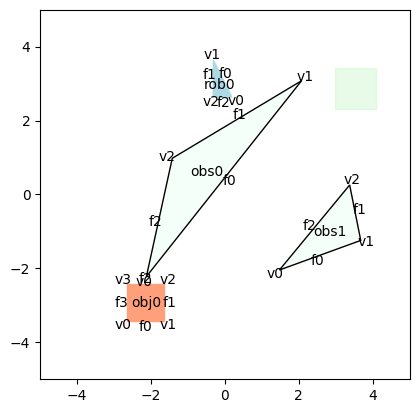

In [2]:
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_maze_a35")
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
)
cg.plot()

In [3]:
vertex_path = [
    "source",
    "('NC|obs0_v0-obj0_f2', 'NC|obs0_f1-rob0_v0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'NC|obj0_f1-rob0_f1')",
    "('NC|obs0_v0-obj0_f2', 'NC|obs0_f2-rob0_v0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'NC|obj0_f1-rob0_f1')",
    "('NC|obs0_v0-obj0_f2', 'NC|obs0_f2-rob0_v0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'NC|obj0_f2-rob0_f2')",
    "('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'NC|obj0_f2-rob0_f2')",
    "('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')",
    "('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_f3-rob0_v0')",
    "('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_v0-rob0_f0')",
    "('NC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_v0-rob0_f0')",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_v0-rob0_f0')",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_f0-rob0_v1')",
    "('IC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_f0-rob0_v1')",
    "('IC|obs0_v1-obj0_f3', 'NC|obs0_f0-rob0_v1', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_f0-rob0_v1')",
    "('IC|obs0_v1-obj0_f3', 'NC|obs0_f0-rob0_v1', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_v0-rob0_f0')",
    "('NC|obs0_v1-obj0_f3', 'NC|obs0_f0-rob0_v1', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_v0-rob0_f0')",
    "('NC|obs0_v1-obj0_f3', 'NC|obs0_f0-rob0_v1', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_f3-rob0_v0')",
    "('NC|obs0_v1-obj0_f3', 'NC|obs0_v1-rob0_f1', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_f3-rob0_v0')",
    "('NC|obs0_v1-obj0_f3', 'NC|obs0_v1-rob0_f1', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'IC|obj0_f2-rob0_f2')",
    "target",
]
cg.set_target("target")
for v in vertex_path[:-1]:
    cg.generate_neighbors(v)

In [4]:
subpath = vertex_path[:5]
subpath

['source',
 "('NC|obs0_v0-obj0_f2', 'NC|obs0_f1-rob0_v0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'NC|obj0_f1-rob0_f1')",
 "('NC|obs0_v0-obj0_f2', 'NC|obs0_f2-rob0_v0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'NC|obj0_f1-rob0_f1')",
 "('NC|obs0_v0-obj0_f2', 'NC|obs0_f2-rob0_v0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'NC|obj0_f2-rob0_f2')",
 "('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'NC|obs1_f2-obj0_v1', 'NC|obs1_f2-rob0_v0', 'NC|obj0_f2-rob0_f2')"]

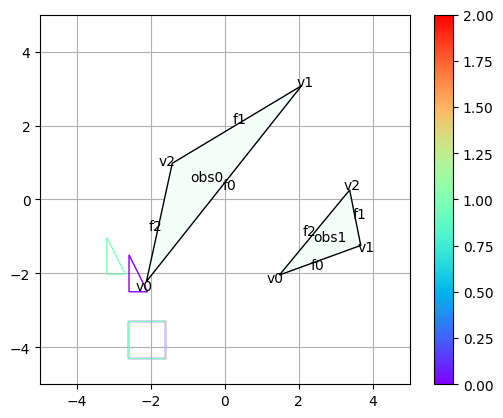

In [5]:
n = SearchNode.from_vertex_path(subpath)
set_samples = SetSamples.from_vertex(n.vertex_name, cg.vertices[n.vertex_name], 1)
# cg.plot_samples_in_set(n.vertex_name, set_samples.samples)

for sample in set_samples.samples:
    cg.plot_samples_in_set(n.vertex_name, np.array([sample]))

In [6]:
# Extract last position knot point from sample

contact_set: ContactSet = cg.vertices[n.vertex_name].convex_set
contact_set.vars.pos

array([[[Variable('obj0_pos(0, 0)', Continuous),
         Variable('obj0_pos(0, 1)', Continuous)],
        [Variable('obj0_pos(1, 0)', Continuous),
         Variable('obj0_pos(1, 1)', Continuous)]],

       [[Variable('rob0_pos(0, 0)', Continuous),
         Variable('rob0_pos(0, 1)', Continuous)],
        [Variable('rob0_pos(1, 0)', Continuous),
         Variable('rob0_pos(1, 1)', Continuous)]]], dtype=object)

In [7]:
last_pos = contact_set.vars.pos[:, :, -1]
last_pos

array([[Variable('obj0_pos(0, 1)', Continuous),
        Variable('obj0_pos(1, 1)', Continuous)],
       [Variable('rob0_pos(0, 1)', Continuous),
        Variable('rob0_pos(1, 1)', Continuous)]], dtype=object)

In [8]:
pos_sample = contact_set.vars.pos_from_all(set_samples.samples[0])
pos_sample

array([[[-2.11760177, -2.11760177],
        [-3.79100253, -3.79100253]],

       [[-2.42768015, -3.02902412],
        [-2.16403978, -1.68801684]]])

In [9]:
last_pos_sample = pos_sample[:, :, -1]
last_pos_sample

array([[-2.11760177, -3.79100253],
       [-3.02902412, -1.68801684]])

In [10]:
from pydrake.all import DecomposeAffineExpressions


exprs = last_pos.flatten() - last_pos_sample.flatten()
A, b = DecomposeAffineExpressions(exprs, contact_set.vars.all)

In [11]:
A

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [12]:
b

array([2.11760177, 3.79100253, 3.02902412, 1.68801684])

In [14]:
from large_gcs.graph.contact_cost_constraint_factory import vertex_constraint_last_pos


constraint = vertex_constraint_last_pos(contact_set.vars, set_samples.samples[0])

In [24]:
from IPython.display import display, Math


display(Math(constraint.ToLatex(contact_set.vars.all)))

<IPython.core.display.Math object>